## Задача

Продолжение разведывательного анализа реальных данных для использования их в экспериментах
с многорукиим бандитами.

### Новые вводные

В результате предыдущих исследований удалось сформулировать статистики, используя которые как критерии,
можно выявлять пользователей, обладающих полезными для исследования свойствами.

1. Разнообразие категорий. Можно находить пользователей, число категорий событий которых, существенно меньше, чем общее число событий.
2. Внутреннее разнообразие категорий. Можно находить пользователей с небольшим числом категорий, представляющих основной интерес. Можно исключать пользователей с одной доминирующей категорией.
3. Сессии. Можно находить пользователей, все события которых распределены по нескольким сессиям (хотя бы более трем).

### Цели и гипотезы текущего исследования

В рамках настоящего исследования, используя уже введенные статистики, рассматриваются пользователи, которые совершают действия в первые два месяца и последние два месяца (всего доступны данные за 5 месяцев).

Для найденных пользователей визуально оценивается изменились ли основные интересы в начале и конце рассматриваемого периода.

## Метод исследования

- Рассчитать введенные ранее статистики, отфильтровать пользователей, используя их как критерии
- Рассчитать для каждого отобранного пользователя признаки-индикаторы совершения действий в начале и конце рассматриваемого периода, отобрать таких пользователей
- Проанализировать визуально логи событий для выбранных пользователей.


In [1]:
import glob

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

DATA_PATH = '../../data/cosmetics_ecommerce_events'
MERGED_DATA_PATH = f'{DATA_PATH}/merged.csv'
RESULTS_PATH = '../../results/cosmetics_ecommerce_events/exploratory_users_category_events_div_peaks_months'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #last_expr

## Загрузка данных и расчет уже известных статистик

In [2]:
df = pd.read_csv(MERGED_DATA_PATH)

In [3]:
df.columns
df.dtypes
df.describe()
df.info()
df.head(10)

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

event_time        object
event_type        object
product_id         int64
category_id        int64
category_code     object
brand             object
price            float64
user_id            int64
user_session      object
dtype: object

product_id   category_id         price       user_id
count  2.069284e+07  2.069284e+07  2.069284e+07  2.069284e+07
mean   5.484297e+06  1.554230e+18  8.534735e+00  5.215527e+08
std    1.305716e+06  1.691038e+17  1.938142e+01  8.744312e+07
min    3.752000e+03  1.487580e+18 -7.937000e+01  4.654960e+05
25%    5.724650e+06  1.487580e+18  2.060000e+00  4.818306e+08
50%    5.810720e+06  1.487580e+18  4.050000e+00  5.531297e+08
75%    5.857864e+06  1.487580e+18  7.060000e+00  5.788573e+08
max    5.932595e+06  2.242903e+18  3.277800e+02  6.220902e+08

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20692840 entries, 0 to 20692839
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 1.4+ GB


event_time event_type  product_id          category_id  \
0  2019-10-01 00:00:00 UTC       cart     5773203  1487580005134238553   
1  2019-10-01 00:00:03 UTC       cart     5773353  1487580005134238553   
2  2019-10-01 00:00:07 UTC       cart     5881589  2151191071051219817   
3  2019-10-01 00:00:07 UTC       cart     5723490  1487580005134238553   
4  2019-10-01 00:00:15 UTC       cart     5881449  1487580013522845895   
5  2019-10-01 00:00:16 UTC       cart     5857269  1487580005134238553   
6  2019-10-01 00:00:19 UTC       cart     5739055  1487580008246412266   
7  2019-10-01 00:00:24 UTC       cart     5825598  1487580009445982239   
8  2019-10-01 00:00:25 UTC       cart     5698989  1487580006317032337   
9  2019-10-01 00:00:26 UTC       view     5875317  2029082628195353599   

  category_code   brand  price    user_id  \
0           NaN  runail   2.62  463240011   
1           NaN  runail   2.62  463240011   
2           NaN  lovely  13.48  429681830   
3           NaN  runail   2.62  463240011   
4           NaN  lovely   0.56  429681830   
5           NaN  runail   2.62  430174032   
6           NaN  kapous   4.75  377667011   
7           NaN     NaN   0.56  467916806   
8           NaN     NaN   1.27  385985999   
9           NaN     NaN   1.59  474232307   

                           user_session  
0  26dd6e6e-4dac-4778-8d2c-92e149dab885  
1  26dd6e6e-4dac-4778-8d2c-92e149dab885  
2  49e8d843-adf3-428b-a2c3-fe8bc6a307c9  
3  26dd6e6e-4dac-4778-8d2c-92e149dab885  
4  49e8d843-adf3-428b-a2c3-fe8bc6a307c9  
5  73dea1e7-664e-43f4-8b30-d32b9d5af04f  
6  81326ac6-daa4-4f0a-b488-fd0956a78733  
7  2f5b5546-b8cb-9ee7-7ecd-84276f8ef486  
8  d30965e8-1101-44ab-b45d-cc1bb9fae694  
9  445f2b74-5e4c-427e-b7fa-6e0a28b156fe

По результатам предыдущего исследования - предлагается рассмотреть только события корзины

In [4]:
df.shape

user_events = df[['user_id', 'user_session', 'event_time', 'product_id', 'event_type', 'price', 'category_id', 'brand']]

user_events = user_events[user_events['event_type'] == 'cart']

user_events.shape

(20692840, 9)

(5768333, 8)

Расчет числа событий для каждого пользователя (только события корзины)

In [6]:
events_count_per_user = user_events.groupby(['user_id'])['event_type'].count()
events_count_per_user.shape

user_stats = events_count_per_user.to_frame().rename(columns={'event_type': 'events_count'})

user_stats['log10_events_count'] = np.log10(user_stats['events_count'])

(398308,)

Расчет разнообразия категорий для каждого пользователя

In [7]:
user_category_stat = user_events.groupby(['user_id'])['category_id'].agg(['nunique', 'count'])
user_category_stat['category_diversity'] = user_category_stat['nunique'] / user_category_stat['count']
user_category_stat = user_category_stat.rename(columns={'nunique': 'category_nunique', 'count': 'category_count'})
user_category_stat = user_category_stat.drop(columns=['category_count'])
user_category_stat.shape

user_stats = user_stats.merge(user_category_stat, how='inner', left_index=True, right_index=True)
user_stats.shape

user_stats[~user_stats['category_diversity'].isna()]

(398308, 2)

(398308, 4)

events_count  log10_events_count  category_nunique  \
user_id                                                         
2963072               7            0.845098                 2   
4103071               1            0.000000                 1   
4661182               2            0.301030                 1   
5493470               5            0.698970                 1   
6217356               2            0.301030                 1   
...                 ...                 ...               ...   
622084170             1            0.000000                 1   
622084975             9            0.954243                 6   
622086066             1            0.000000                 1   
622089692             1            0.000000                 1   
622090043             1            0.000000                 1   

           category_diversity  
user_id                        
2963072              0.285714  
4103071              1.000000  
4661182              0.500000  
5493470              0.200000  
6217356              0.500000  
...                       ...  
622084170            1.000000  
622084975            0.666667  
622086066            1.000000  
622089692            1.000000  
622090043            1.000000  

[398308 rows x 4 columns]

Расчет внутреннего разнообразия категорий для каждого пользователя

In [8]:
user_category_stat = user_events.groupby(['user_id', 'category_id'])['category_id'].agg(['count'])
user_category_stat = user_category_stat.reset_index(level='category_id')

user_stats_comp = user_stats.merge(user_category_stat, how='inner', left_index=True, right_index=True)
user_stats_comp['user_category_rel_square'] = np.square(user_stats_comp['count'] / user_stats_comp['events_count'])

user_stats_comp.shape

inner_category_diversity = 1 - user_stats_comp.groupby(['user_id'])['user_category_rel_square'].sum()
inner_category_diversity = inner_category_diversity.to_frame().rename(columns={'user_category_rel_square': 'inner_category_diversity'})

user_stats = user_stats.merge(inner_category_diversity, how='inner', left_index=True, right_index=True)
user_stats.shape
user_stats
# user_stats[~user_stats['category_diversity'].isna()]


(1774344, 7)

(398308, 5)

events_count  log10_events_count  category_nunique  \
user_id                                                         
2963072               7            0.845098                 2   
4103071               1            0.000000                 1   
4661182               2            0.301030                 1   
5493470               5            0.698970                 1   
6217356               2            0.301030                 1   
...                 ...                 ...               ...   
622084170             1            0.000000                 1   
622084975             9            0.954243                 6   
622086066             1            0.000000                 1   
622089692             1            0.000000                 1   
622090043             1            0.000000                 1   

           category_diversity  inner_category_diversity  
user_id                                                  
2963072              0.285714                  0.244898  
4103071              1.000000                  0.000000  
4661182              0.500000                  0.000000  
5493470              0.200000                  0.000000  
6217356              0.500000                  0.000000  
...                       ...                       ...  
622084170            1.000000                  0.000000  
622084975            0.666667                  0.790123  
622086066            1.000000                  0.000000  
622089692            1.000000                  0.000000  
622090043            1.000000                  0.000000  

[398308 rows x 5 columns]

## Формирование подвыборки пользователей и расчет остальных статистик

Расчет числа сессий и индикаторов совершения покупок в каждый из месяцев вычислительно трудоемок, поэтому осуществляется для отобранной на основе рассчитанных статистик подвыборки пользователей.

Подвыборка формируется с более слабыми ограничениями относительно предыдущих исследований:
- разнообразие категорий меньше 0.2 (против 0.1)
- внутреннее разнообразие категорий больше 0.5 (против диапазона 0.5; 0.6)

Это сделано, чтобы оставить больше возможностей для фильтрации пользователей, совершавших действия в начале и конце рассматриваемого диапазона.

In [9]:
predicate = (user_stats['category_diversity'] < 0.2)\
  & (user_stats['events_count'] > 100)\
  & (user_stats['inner_category_diversity'] > 0.5)
len(user_stats[predicate])

selected = user_stats[predicate]

pd.set_option('display.max_rows', len(selected))
selected
pd.reset_option('display.max_rows')


4518

events_count  log10_events_count  category_nunique  \
user_id                                                         
10280338            212            2.326336                19   
31156111            183            2.262451                30   
31272873            198            2.296665                38   
34033932            391            2.592177                28   
50764735            145            2.161368                16   
53613286            215            2.332438                14   
56612519            326            2.513218                50   
65241811            103            2.012837                17   
72140588            353            2.547775                42   
72931003            191            2.281033                31   
75649789            199            2.298853                19   
83998413            207            2.315970                34   
86528611            131            2.117271                15   
91136858            261            2.416641                34   
105118203           208            2.318063                31   
107945915           317            2.501059                39   
115398528           147            2.167317                24   
127274675           220            2.342423                43   
131994138           793            2.899273                67   
146699059           182            2.260071                34   
151229872           161            2.206826                15   
153316955           531            2.725095                69   
153836569           175            2.243038                34   
154065884           215            2.332438                28   
159260812           165            2.217484                29   
159277817           211            2.324282                16   
160905182           185            2.267172                27   
170061254           165            2.217484                21   
170386254           231            2.363612                39   
172368833           196            2.292256                31   
175907430           936            2.971276                83   
176064797           385            2.585461                52   
181122527           101            2.004321                12   
181678993           330            2.518514                34   
184386547           137            2.136721                27   
185694683           220            2.342423                28   
186020703           252            2.401401                49   
187565158           316            2.499687                35   
187697719           122            2.086360                24   
188740654           128            2.107210                24   
195176258           125            2.096910                11   
197439968           131            2.117271                19   
199598006           302            2.480007                22   
200698039           381            2.580925                65   
201744074           395            2.596597                42   
201813707           159            2.201397                22   
202472817           285            2.454845                15   
202874168           189            2.276462                31   
204142009           123            2.089905                21   
204147137           152            2.181844                28   
204598976           225            2.352183                24   
204668884           109            2.037426                12   
206707690           239            2.378398                44   
209625145           654            2.815578                68   
215450430           163            2.212188                15   
219271433           287            2.457882                24   
220965197           224            2.350248                24   
222225189           360            2.556303                58   
224068566           464            2.666518                67   
226926308           130            2.113943   

Отобрано 4518 пользователей из 398308 (против 119 в предыдущем исследовании)

Рассчитаем число сессий каждого пользователя и индикаторы совершения действия пользователем в каждом из пяти месяцев.

In [10]:
from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks


def compute_log_density_and_peaks(selected_user_events, for_better_vis=False):

    np.random.seed(1)
    
    selected_user_events['event_time'] = pd.to_datetime(selected_user_events['event_time'])
    
    selected_user_events = selected_user_events.sort_values(by=['event_time'], kind='mergesort')

    selected_user_events['time_delta'] = selected_user_events['event_time'] - selected_user_events.iloc[0]['event_time']
    selected_user_events['time_delta_sec'] = selected_user_events['time_delta'].apply(lambda x: x.total_seconds())

    x = selected_user_events[['time_delta_sec']]
    
    #print(x['time_delta_sec'].max())

    if for_better_vis:
        bwdth = x['time_delta_sec'].max() / 200 # used for better presentation
    else:
        bwdth = 3600 # use to find peaks
    
    x = x + 2 * bwdth
    #print(f'bandwidth: {bwdth}')

    kde = KernelDensity(kernel='gaussian', bandwidth=bwdth).fit(x)

    # 0 to max(x['time_delta_sec']) + bwdth to end not with max ((to get smooth ending))
    space = np.linspace(0, max(x['time_delta_sec']) + 2 * bwdth, 1000).reshape(-1, 1)
    log_density = kde.score_samples(space)
    
    peaks = find_peaks(np.exp(log_density))
    return log_density, kde, space, peaks, space[peaks[0]]

In [11]:
def compute_months_events_indicators(selected_user_events):
    user_events_months = pd.to_datetime(selected_user_events['event_time']).apply(lambda x: x.month)
    #res = user_events_date_times.apply(lambda x: x.month)
    oct_m = user_events_months.isin([10]).any()
    nov_m = user_events_months.isin([11]).any()
    dec_m = user_events_months.isin([12]).any()
    jan_m = user_events_months.isin([1]).any()
    feb_m = user_events_months.isin([2]).any()
    return oct_m, nov_m, dec_m, jan_m, feb_m
    

In [13]:
selected_users_events = user_events[user_events['user_id'].isin(selected.index)]
selected_users_events.shape

grouped_users_events = selected_users_events.groupby('user_id')
selected_users_stats = selected.assign(peaks_count = np.nan, has_oct_events = np.nan, has_nov_events = np.nan,\
                                       has_dec_events = np.nan, has_jan_events = np.nan, has_feb_events = np.nan)
for name, group in grouped_users_events:
    _, _, _, peaks_nums, peaks = compute_log_density_and_peaks(group)
    selected_users_stats.at[name, 'peaks_count'] = len(peaks)
    months_events_indicators = compute_months_events_indicators(group)
    selected_users_stats.at[name, ['has_oct_events', 'has_nov_events', 'has_dec_events',
                                  'has_jan_events', 'has_feb_events']] = months_events_indicators


(1129336, 8)

## Отбор пользователей, активных в начале и конце рассматриваемого периода

С рассчитанными индикторами совершения покупок отберем пользователей, которые совершали действия в первые два месяца (хотя бы в один из) и последние два месяца (хотя бы один из).

In [14]:
oct_nov_jan_feb_users = selected_users_stats[((selected_users_stats['has_oct_events'] \
                                             | selected_users_stats['has_nov_events']) \
                                             & (selected_users_stats['has_jan_events'] \
                                             | selected_users_stats['has_feb_events']))]


selected_users_stats.shape
oct_nov_jan_feb_users.shape

other_users_stats = selected_users_stats[~selected_users_stats.index.isin(oct_nov_jan_feb_users.index)]
other_users_stats.shape

(4518, 11)

(2754, 11)

(1764, 11)

Среди отобранных на предыдущем шаге 4518 пользователей, 2754 совершали покупки в начале и конце рассматриваемого периода, 1764 - нет.

Сравним отобранных пользователей с остальными, отобранными на предедыщуем шаге, по основным статистикам - разнообразие категорий, внутреннее разнообразие категорий, количество пиков.

In [15]:
from IPython.core.interactiveshell import InteractiveShell
current_ast_node_interactivity = InteractiveShell.ast_node_interactivity
InteractiveShell.ast_node_interactivity = "last_expr"

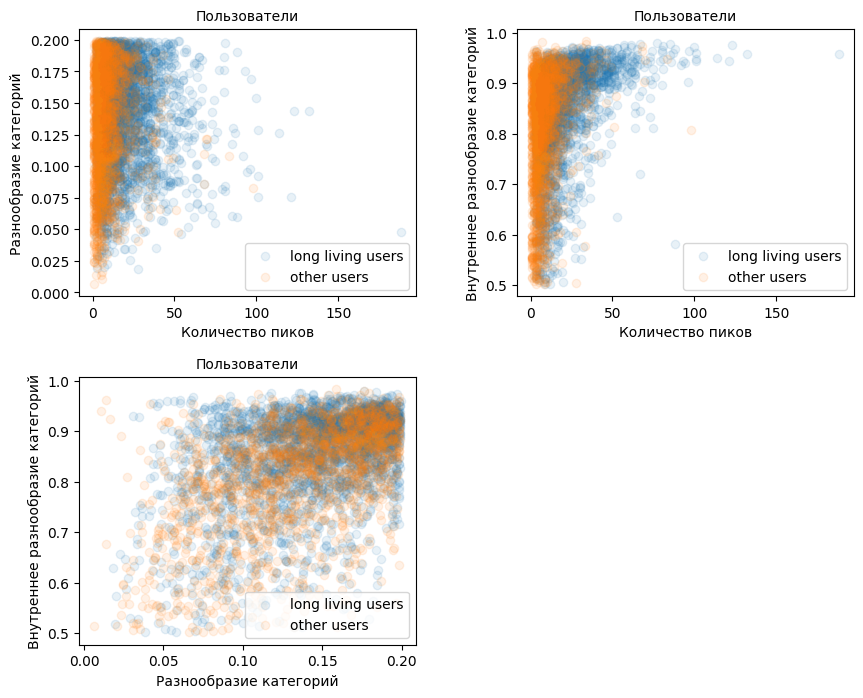

In [16]:
fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.subplot(221)
plt.xlabel('Количество пиков')
plt.ylabel('Разнообразие категорий')
plt.title('Пользователи', size=10)
plt.scatter(oct_nov_jan_feb_users['peaks_count'], oct_nov_jan_feb_users['category_diversity'], alpha=0.1, \
            label='long living users')
plt.scatter(other_users_stats['peaks_count'], other_users_stats['category_diversity'], alpha=0.1, \
            label='other users')
plt.legend()

plt.subplot(222)
plt.xlabel('Количество пиков')
plt.ylabel('Внутреннее разнообразие категорий')
plt.title('Пользователи', size=10)
plt.scatter(oct_nov_jan_feb_users['peaks_count'], oct_nov_jan_feb_users['inner_category_diversity'], alpha=0.1, \
            label='long living users')
plt.scatter(other_users_stats['peaks_count'], other_users_stats['inner_category_diversity'], alpha=0.1, \
            label='other users')
plt.legend()

plt.subplot(223)
plt.xlabel('Разнообразие категорий')
plt.ylabel('Внутреннее разнообразие категорий')
plt.title('Пользователи', size=10)
plt.scatter(oct_nov_jan_feb_users['category_diversity'], oct_nov_jan_feb_users['inner_category_diversity'], alpha=0.1, \
            label='long living users')
plt.scatter(other_users_stats['category_diversity'], other_users_stats['inner_category_diversity'], alpha=0.1, \
            label='other users')
plt.legend()

plt.savefig(f'{RESULTS_PATH}/diversity_peaks_long_living_users.png', dpi=300)

In [17]:
InteractiveShell.ast_node_interactivity = current_ast_node_interactivity

Можно отметить, что две подвыборки пользователей не отличимы с точки зрения статистик разнообразия категорий и внутреннего разнообразия категорий.

Однако, у пользователей, совершивших действия в начале и конце временного диапазона, большее число сессий.

С учетом полученной визуализации, еще отфильтруем пользователей:
- разнообразие категорий меньше 0.1
- число сессий больше 40

In [19]:
len(oct_nov_jan_feb_users)
predicate = ((oct_nov_jan_feb_users['peaks_count'] > 40) \
  & (oct_nov_jan_feb_users['category_diversity'] < 0.1))
len(oct_nov_jan_feb_users[predicate])

selected = oct_nov_jan_feb_users[predicate]
np.random.seed(1)
selected_subset_users_ids = selected.iloc[np.random.choice(len(selected), 20, replace=False)].index

selected_subset_users_ids

# pd.set_option('display.max_rows', len(selected))
# selected
# pd.reset_option('display.max_rows')



2754

60

Int64Index([523418374, 528379472, 355374962, 548400513, 549941895, 534195224,
            497799481, 506879897, 525096456, 478274794, 468907816, 551119191,
            539691934, 382261190, 476180402, 521279428, 460604788, 414090241,
            551114613, 459540377],
           dtype='int64', name='user_id')

В финальную подвыборку отобраны 60 пользователей.

## Визуальные анализ логов событий отобранных пользователей (совершивших покупки в начале и конце рассматриваемого периода)

In [20]:
user_id = 399445659 

In [ ]:
np.random.seed(1)

selected_user_events = user_events[user_events['user_id'] == user_id]

selected_user_events.shape

selected_user_events['event_time'] = pd.to_datetime(selected_user_events['event_time'])

selected_user_events = selected_user_events.sort_values(by=['event_time'], kind='mergesort')

selected_user_events['time_delta'] = selected_user_events['event_time'] - selected_user_events.iloc[0]['event_time']
selected_user_events['time_delta_sec'] = selected_user_events['time_delta'].apply(lambda x: x.total_seconds())

pd.set_option('display.max_rows', len(selected_user_events))
selected_user_events
pd.reset_option('display.max_rows')

In [22]:
from IPython.core.interactiveshell import InteractiveShell
current_ast_node_interactivity = InteractiveShell.ast_node_interactivity
InteractiveShell.ast_node_interactivity = "last_expr"

In [ ]:
user_id = 399445659 

def plot_user_density(user_id, savefig=False, suffix=None):
    selected_user_events = user_events[user_events['user_id'] == user_id]

    log_density, kde, space, peaks_nums, peaks = compute_log_density_and_peaks(selected_user_events)

    plt.figure(figsize=(10,3))
    plt.plot(space / (3600 * 24), np.exp(log_density))
    plt.xlabel('Время, сутки')
    plt.ylabel('Плотность')
    plt.title(f'Восстановленная плотность событий корзины пользователя {user_id}', size=9)

    peaks
    len(peaks)
    
    if savefig:
        if suffix:
            plt.savefig(f'{RESULTS_PATH}/{suffix}/user_{user_id}_density.png', dpi=300)
        else:
            plt.savefig(f'{RESULTS_PATH}/user_{user_id}_density.png', dpi=300)        
    plt.close(fig)
        
# plot_user_density(user_id)

# plt.ion()


In [ ]:
user_ids = [523418374, 528379472, 355374962, 548400513, 549941895, 534195224,
            497799481, 506879897, 525096456, 478274794, 468907816, 551119191,
            539691934, 382261190, 476180402, 521279428, 460604788, 414090241,
            551114613, 459540377]

for user_id in user_ids:
    plot_user_density(user_id)

# plt.close('all')
# plt.ion()

In [25]:
user_id = 549941895

def plot_user_events(user_id, savefig=False, suffix=None):
    one_user_events = user_events[user_events['user_id'] == user_id]
    one_user_events = one_user_events[['event_time', 'category_id']]
    one_user_events['event_time'] = pd.to_datetime(one_user_events['event_time'])

    one_user_events['time_delta'] = one_user_events['event_time'] - one_user_events.iloc[0]['event_time']
    one_user_events['time_delta_sec'] = one_user_events['time_delta'].apply(lambda x: x.total_seconds())
    one_user_events['time_delta_hrs'] = one_user_events['time_delta'].apply(lambda x: x.total_seconds()/(60 * 60))
    one_user_events['time_delta_days'] = one_user_events['time_delta_hrs'].apply(lambda x: x / 24)
    one_user_events['category_id_str'] = one_user_events['category_id'].apply(lambda x: str(x))

    fig = plt.figure(figsize=(10,3))
    ax = sns.catplot(data=one_user_events, x="time_delta_days", y="category_id_str", jitter=0.25, height=4, aspect=9/4)
    plt.setp(ax.ax.collections, alpha=.5)
    ax.ax.set_title(f'События корзины по времени, пользователь {user_id}')
    ax.ax.set_xlabel('Время, дней')
    ax.ax.tick_params(axis='y', which='major', labelsize='small')
    ax.ax.set_ylabel('Категория')

    if savefig:
        if suffix:
            plt.savefig(f'{RESULTS_PATH}/{suffix}/user_{user_id}_category_events.png', dpi=300)
        else:
            plt.savefig(f'{RESULTS_PATH}/user_{user_id}_category_events.png', dpi=300)        
    plt.close(fig)
        
# plot_user_events(user_id)

# plt.ion()

In [ ]:
# plt.ioff()

user_ids = [523418374, 528379472, 355374962, 548400513, 549941895, 534195224,
            497799481, 506879897, 525096456, 478274794, 468907816, 551119191,
            539691934, 382261190, 476180402, 521279428, 460604788, 414090241,
            551114613, 459540377]

for user_id in user_ids:
    plot_user_events(user_id)

# plt.close('all')
# plt.ion()

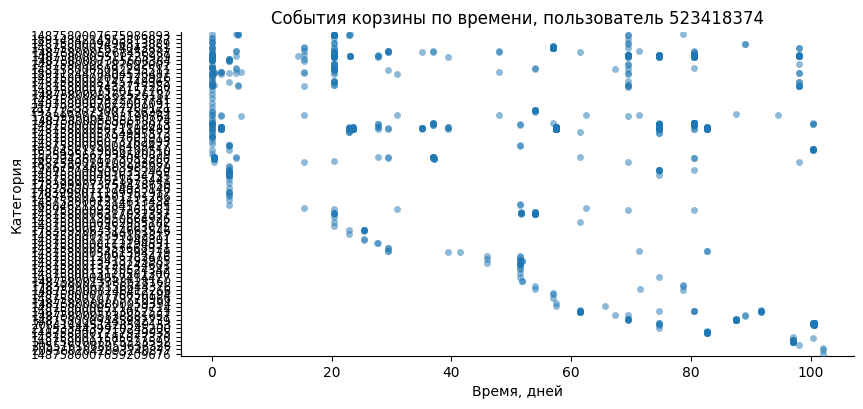

In [27]:
plot_user_events(523418374)

Наблюдается смена интересов относительно начала и конца рассматриваемого периода.

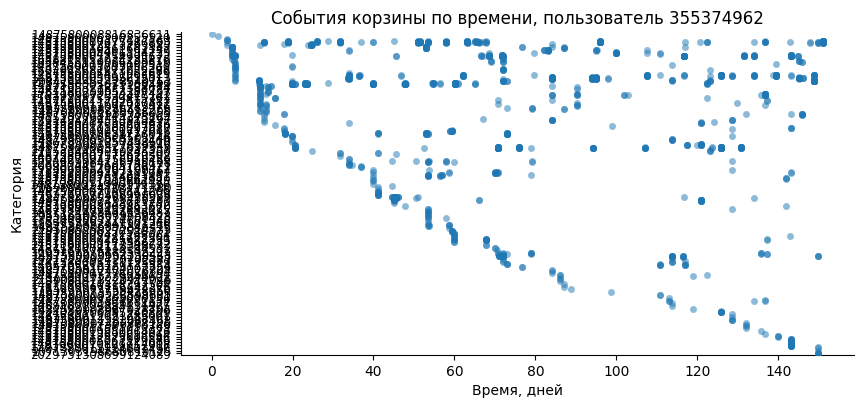

In [28]:
plot_user_events(355374962)

Наблюдается смена интересов относительно начала и конца рассматриваемого периода.

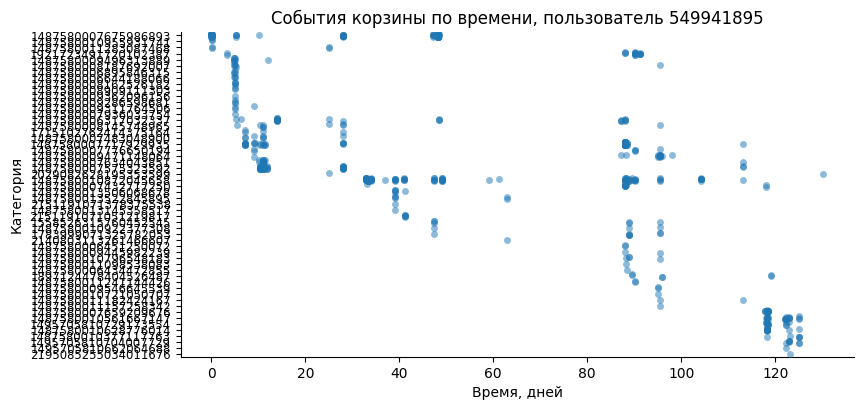

In [29]:
plot_user_events(549941895)

Наблюдается смена интересов относительно начала и конца рассматриваемого периода.

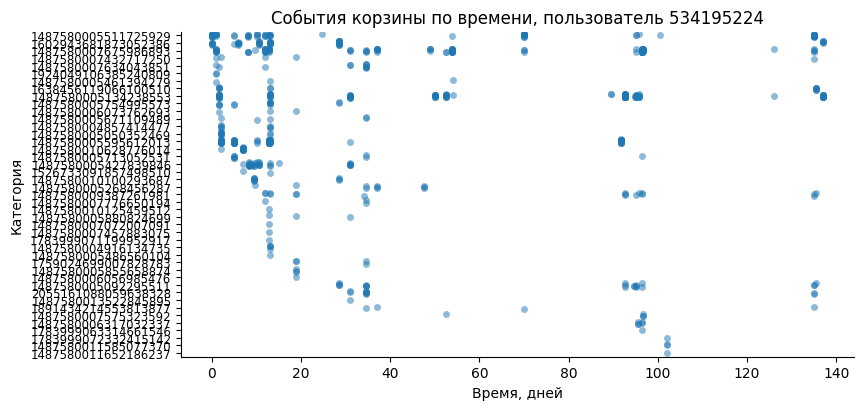

In [30]:
plot_user_events(534195224)

Наблюдается снижение разнообразия.

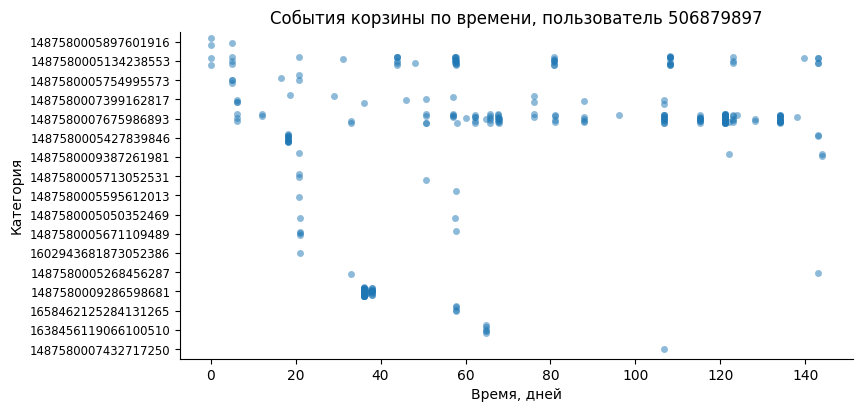

In [31]:
plot_user_events(506879897)

Интересы сохраняются в течение рассматриваемого периода.

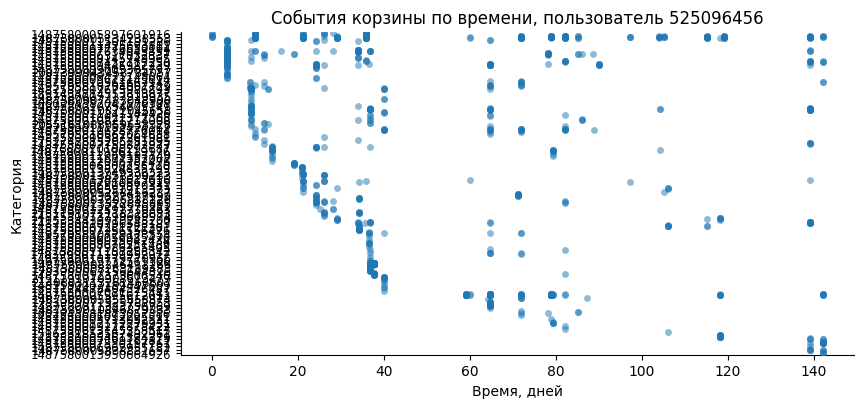

In [32]:
plot_user_events(525096456)

Наблюдается смена интересов относительно начала и конца рассматриваемого периода.

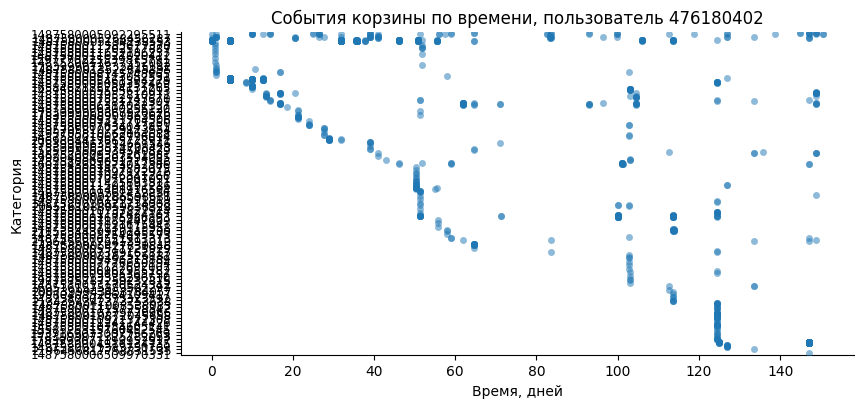

In [34]:
plot_user_events(476180402)

Наблюдается смена интересов относительно начала и конца рассматриваемого периода.

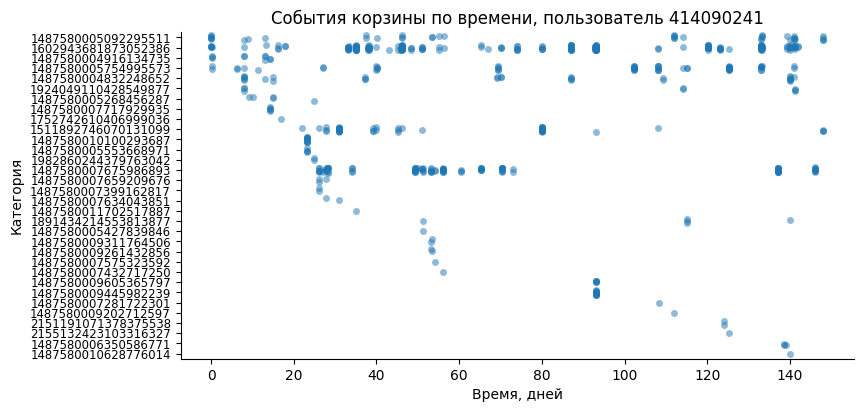

In [35]:
plot_user_events(414090241)

Интересы сохраняются в течение рассматриваемого периода.

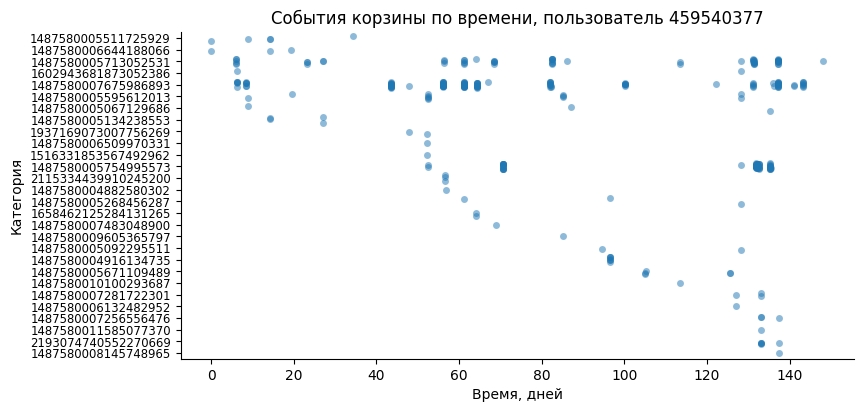

In [38]:
plot_user_events(459540377)

Интересы сохраняются в течение рассматриваемого периода.

In [39]:
InteractiveShell.ast_node_interactivity = current_ast_node_interactivity

## Выводы

Проведенный анализ позволил выявить пользователей, которые как сохраняют, так и изменяют свои интересы с течением времени.

Найденные пользователи могут быть полезны для экспериментов с бандитскими алгоритмами.